# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



# Let's start by the minimum requirements.


In [241]:
from tabulate import tabulate
from IPython.display import display, HTML
import pandas as pd


# Read the file ...
file_path = 'alldata.xlsx'
df = pd.read_excel(file_path)

# Let's display the data head without collapsing it to visualize what columns of data we have :)
display(HTML(tabulate(df.head(), headers='keys', tablefmt='html')))
pd.set_option('display.max_rows', None)



,530,531,533,534,535,537,538,540,541,543,544,545,546,547,548,550,551,552,553,555,556,557,559,561,563,navn,parti,1a,1b,2a,2b,3a,3b,4a,4b,5a,5b,6a,6b,7a,7b,8a,8b,9a,9b,10a,10b,11a,11b,12a,12b,storkreds,alder
0,-1,-2,1,-2,2,1,-2,1,1,2,-2,1,2,2,1,-2,1,2,-2,2,2,1,2,2,-2,Lars Philipsen Prahm,Moderaterne,0,0,2,2,2,-2,-1,0,-1,1,-1,1,2,2,1,0,2,0,1,-2,-2,1,1,1,Københavns Storkreds,78
1,2,2,-1,-2,-1,-2,1,-2,2,-2,2,-1,-2,-2,2,2,-2,1,1,-1,-2,1,2,1,2,Karsten Hønge,Socialistisk Folkeparti,1,1,1,1,1,2,2,2,-2,0,1,-2,-2,0,0,0,-2,0,-1,2,1,-2,0,0,Fyns Storkreds,64
2,2,1,-2,-2,1,-2,1,-1,1,-1,2,-2,-2,-1,1,1,-2,2,-1,-2,-1,1,2,2,2,Martin Kelleher-Petersen,Alternativet,1,1,1,2,1,1,2,0,-1,1,2,-2,-2,-2,1,1,-1,-2,0,2,0,-1,1,-2,Bornholms Storkreds,37
3,2,1,-2,-1,1,1,1,1,1,-2,2,1,1,-2,2,2,-2,2,1,2,-2,2,2,2,2,Nicklas Gjedsig Larsen,Alternativet,2,2,2,2,0,2,0,2,-2,2,-1,2,0,-2,2,2,-2,2,2,2,2,-1,2,0,Nordjyllands Storkreds,28
4,1,1,-2,2,-2,1,-2,1,2,-2,-2,2,2,-2,2,1,-2,2,-2,-2,-1,1,-2,-1,-2,Tom Gillesberg,Løsgænger,-2,-2,0,0,-2,-2,2,1,-2,2,1,-2,2,-2,1,0,-2,0,-1,0,-2,0,2,-2,Københavns Storkreds,58


In [242]:
# I would also like to print out a list with all the parties just so I know what we're working with.

# Rename frie gronne coz the name was huge
df['parti'] = df['parti'].replace({'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Frie Grønne'})

grouped_by_party = df.groupby('parti')
display(grouped_by_party['parti'].unique())

# Well, the output looks kinda weird but I got the idea :)


parti
Alternativet                          [Alternativet]
Danmarksdemokraterne           [Danmarksdemokrate...
Dansk Folkeparti                  [Dansk Folkeparti]
Det Konservative Folkeparti    [Det Konservative ...
Enhedslisten                          [Enhedslisten]
Frie Grønne                            [Frie Grønne]
Kristendemokraterne            [Kristendemokraterne]
Liberal Alliance                  [Liberal Alliance]
Løsgænger                                [Løsgænger]
Moderaterne                            [Moderaterne]
Nye Borgerlige                      [Nye Borgerlige]
Radikale Venstre                  [Radikale Venstre]
Socialdemokratiet                [Socialdemokratiet]
Socialistisk Folkeparti        [Socialistisk Folk...
Venstre                                    [Venstre]
Name: parti, dtype: object

Furthermore, it seems like a good idea to print out the number of candidates in each party just to have an overview and draw more informed conclusions.

In [243]:
party_candidate_count = grouped_by_party.size().reset_index(name='Candidate_Count')

print(party_candidate_count)

                    parti  Candidate_Count
0            Alternativet               67
1    Danmarksdemokraterne               37
2        Dansk Folkeparti               49
3   Det Konservative F...               98
4            Enhedslisten               74
5             Frie Grønne               26
6     Kristendemokraterne               42
7        Liberal Alliance               70
8               Løsgænger                3
9             Moderaterne               42
10         Nye Borgerlige               51
11       Radikale Venstre               67
12      Socialdemokratiet               87
13  Socialistisk Folke...               70
14                Venstre               84


One interesting thing to note is that there are only 3 candidates not affiliated to any party (Løsgænger). When training our model, it seems like it would be wise to drop these candidates for the training data - and it could also be interesting to make predictions on them and see which party they could belong to, alongside the confidence of our models' predictions of that! :)

### Now, moving onto the analysis of the candidates' age.

Before making the analysis for the age among candidates, it's a good idea to clean up the data.
For this, I will make a dataframe with only the name of the candidate, the party they belong to and their age. I will remove the candidates with age 0 because that missing information could mess up our analysis, and in this case, we can afford to drop a couple candidates since we're exclusively looking at age.

In [244]:
pd.set_option('display.max_colwidth', 30)

desired_columns = ['alder', 'navn', 'parti']
age_analysis_df = df[desired_columns].sort_values(by='alder')
age_analysis_df = age_analysis_df[age_analysis_df['alder'] != 0]


Now, to make the graph and analyse it.

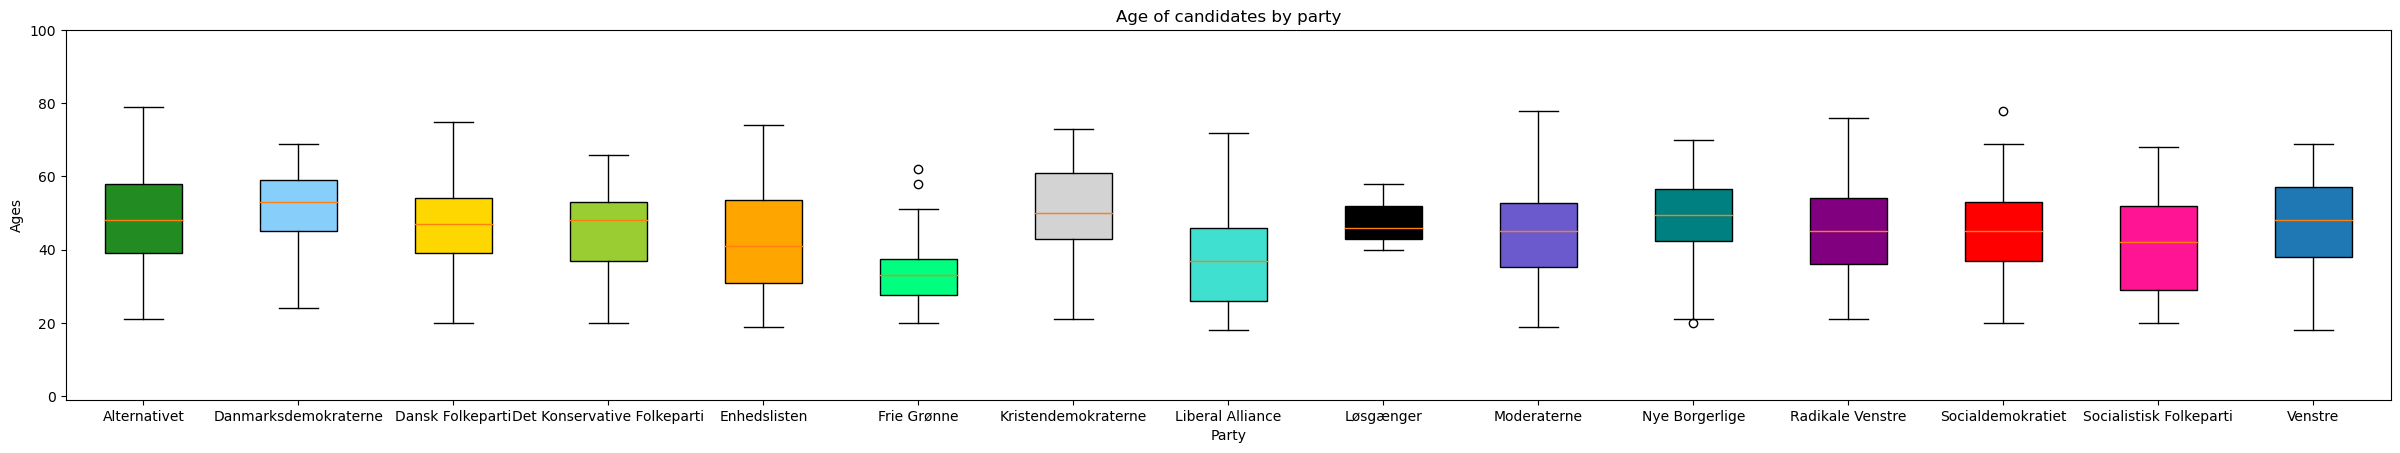

In [245]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot()

# Creating color array to match the colors to the parties as specified above... this took a while ;p
box_colors = ['forestgreen', 'lightskyblue', 'gold', 'yellowgreen', 'orange', 'springgreen', 'lightgray','turquoise', 'black', 'slateblue', 'teal','purple', 'red',  'deeppink']

age_by_party = age_analysis_df.groupby('parti')

alder_boxplot = ax.boxplot([group['alder'] for name, group in age_by_party], labels=age_by_party.groups.keys(), patch_artist=True)

for patch, color in zip(alder_boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

ax.set_xlabel('Party')
ax.set_ylabel('Ages')
ax.set_title('Age of candidates by party')

ax.set_ylim([-1, 100])

fig.set_figwidth(30)

plt.show()

It's wise to disregard Løsgænger since they are not affiliated with any party and they are only 3 candidates.

Analyzing the boxplot above, let's make some observations:

- Most parties' oldest members are around 70-80 years old.
- The parties with the youngest oldest members are Denmarksdemokraterne, Det Konservative Folkeparti and Frie Gronne (with the oldest party member at ~70 years old).
- All parties have young candidates in their 20s.
- The parties with the biggest percentage of young people seem to be Enhedslisten, Frie Grønne, Liberal Alliance Party and Socialitisk Folkeparti, all featuring a very narrow Q1 between 20 and 30 years old (aka 25% of their members lie in this age range.)
- The parties with a normal distribution of age seem to be Alternativet, Danske Folkeparti and Radikale Venstre, considering the size of each of their Qs (very dense population in the average values, more scattered on the edge values).
- Looking at the size of the Q1 in Kristendemokraterne, Nye Borgerlige and Venstre, it seems like these are the oldest parties, since the range of their youngest members is so wide (meaning that most members are on the older spectrum).

# Now, let's analyze the most confident candidates.

In [246]:
# First, let's see get the columns refer to the answers.
# I have found that these were between the ranges of 0-25 and 28-51.

answer_columns = list(range(0, 25)) + list(range(28, 51))

# Next, let's sum up the absolute value of their answers. This means that candidates
# with a lot of 2 and -2 answers would have a high score of answer_confidence.
df['answer_confidence'] = df.iloc[:, answer_columns].abs().sum(axis=1)

# Sort it to see the most confident at the top
df_conf = df.sort_values(by='answer_confidence', ascending=False)

# Great, we have the confidence of each candidate! But it's not very readable.
# Let's put the answer confidence, the candidate name and their party at the beginning
# of the table to observe the results better.

column_to_move = 'answer_confidence'
df_conf.insert(0, column_to_move, df_conf.pop(column_to_move))

column_to_move = 'navn'
df_conf.insert(0, column_to_move, df_conf.pop(column_to_move))

column_to_move = 'parti'
df_conf.insert(0, column_to_move, df_conf.pop(column_to_move))

# And display it
display(HTML(tabulate(df_conf.head(30), headers='keys', tablefmt='html')))






,parti,navn,answer_confidence,530,531,533,534,535,537,538,540,541,543,544,545,546,547,548,550,551,552,553,555,556,557,559,561,563,1a,1b,2a,2b,3a,3b,4a,4b,5a,5b,6a,6b,7a,7b,8a,8b,9a,9b,10a,10b,11a,11b,12a,12b,storkreds,alder
88,Det Konservative Folkeparti,Søren Vanting,96,-2,-2,2,-2,2,2,-2,2,-2,-2,-2,-2,2,-2,-2,-2,-2,-2,-2,-2,2,-2,-2,2,2,-2,-2,-2,-2,2,-2,-2,2,-2,2,-2,-2,-2,2,2,2,-2,2,2,-2,-2,2,2,-2,Østjyllands Storkreds,50
505,Enhedslisten,Sarah Nørris,96,2,2,-2,2,-2,-2,2,-2,2,-2,2,-2,-2,-2,2,2,-2,2,2,-2,-2,2,2,2,2,2,2,2,2,-2,2,2,2,-2,-2,2,-2,-2,-2,-2,-2,-2,-2,-2,2,2,-2,-2,-2,Sydjyllands Storkreds,43
44,Frie Grønne,Mohamed Abdikarim,90,2,2,-2,-1,-2,-2,-2,-2,2,-2,2,1,-2,-2,2,2,-2,2,-2,-2,-2,2,2,2,2,2,2,2,2,-2,2,2,2,-2,-1,2,-2,-2,-1,-1,-1,-2,-2,-2,2,-2,2,-2,-2,Østjyllands Storkreds,33
503,Enhedslisten,Jan Filbært,90,2,2,-2,2,-2,-2,-2,-2,2,-2,2,-2,-2,-2,2,1,-2,-2,2,-2,-2,1,2,1,2,-1,2,2,-1,-2,1,2,2,-2,2,2,-2,-2,2,2,-2,-2,-1,-2,2,-2,-2,-2,2,Sydjyllands Storkreds,57
359,Dansk Folkeparti,Frank Sørensen,89,-1,-2,-2,2,2,1,-2,2,-2,-2,-2,1,2,-2,2,-2,2,2,1,2,-2,2,2,-1,2,-2,-2,2,-2,2,-2,-2,2,-1,2,-2,2,2,2,2,2,2,2,1,2,-2,2,2,-2,Fyns Storkreds,58
810,Frie Grønne,Asham Nadeem,89,2,2,-2,-2,-2,-2,-2,-2,2,-2,2,-2,-2,-2,2,2,-2,-2,-2,-2,-2,2,2,2,2,1,2,2,1,-2,2,2,2,-1,1,2,-2,-2,2,2,1,-2,1,-2,2,-2,2,1,1,Københavns Omegns Storkreds,26
151,Frie Grønne,Elise Bjerkrheim,88,2,2,-2,-2,-2,-2,-1,-2,2,-2,2,1,-2,-2,2,2,-2,2,-2,-2,-2,2,2,2,2,2,2,2,2,-2,2,2,1,-2,2,2,-2,-2,2,2,2,-2,-2,-2,2,-1,1,-1,0,Københavns Storkreds,48
152,Frie Grønne,Rashid Ali,88,2,2,-2,-2,-2,-2,-2,-2,2,-2,2,1,-2,-2,2,2,-2,2,-2,-2,-2,2,2,2,2,2,2,2,1,-2,2,2,2,-2,2,2,-2,-2,-2,2,-1,-2,2,0,2,1,2,-2,0,Københavns Storkreds,38
437,Dansk Folkeparti,Lone Vase Langballe,88,-1,-1,2,2,2,1,-1,2,1,2,-2,-2,2,-2,-2,-2,2,-2,-1,2,-2,2,-2,-2,-2,-2,-2,2,2,2,2,0,2,-2,2,-2,2,2,2,-2,2,-2,-2,2,2,-2,2,2,-2,Vestjyllands Storkreds,52
338,Enhedslisten,Camilla Dalum Jensen,87,2,2,-2,1,-2,-2,-2,-2,2,-2,2,-2,1,-2,2,2,-2,2,1,-2,-2,2,2,2,2,1,2,2,-2,-2,2,2,2,-2,2,2,-2,-1,1,2,2,-2,2,-2,2,1,-1,-1,1,Fyns Storkreds,21


Observing the result above, we can infer that the parties with the most extreme ideals are the following, which were the most apparent in the top 30 most confident candidates:

- Enhedslisten
- Frie Grønne
- Dansk Folkeparti

and, to a lesser degree:

- Nye Borgerlige
- Liberal Alliance

The most confident candidates are Søren Vanting from Det Konservative Folkeparti (which is kind of an outlier, because no one else from this party made it to the top30) and Sarah Nørris from Enhedslisten, which aligns with our observations. Both had a score of 96 answer confidence.

## But what about the /least/ confident candidates? Could it also be interesting to take a look at these? Let's print out the bottom of the confidence table and see if we find any patterns.

In [247]:
display(HTML(tabulate(df_conf.tail(30), headers='keys', tablefmt='html')))


,parti,navn,answer_confidence,530,531,533,534,535,537,538,540,541,543,544,545,546,547,548,550,551,552,553,555,556,557,559,561,563,1a,1b,2a,2b,3a,3b,4a,4b,5a,5b,6a,6b,7a,7b,8a,8b,9a,9b,10a,10b,11a,11b,12a,12b,storkreds,alder
315,Venstre,Birthe Tindbæk Bredo,46,-1,-1,1,-2,2,1,-2,1,-2,1,-1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,-1,-1,1,0,1,1,1,1,-1,0,1,0,0,-1,2,0,1,1,0,-1,0,0,2,-1,2,0,0,Bornholms Storkreds,63
509,Danmarksdemokraterne,Michael Mikkelsen,46,-1,-1,1,-1,1,0,-1,1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,0,1,-1,1,-1,1,-1,1,1,1,1,-1,1,1,-1,1,1,1,Sydjyllands Storkreds,50
138,Venstre,Alexandra Sasha,46,1,-1,-1,-2,1,1,-2,1,-1,1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,1,1,-1,1,0,1,1,0,1,1,1,1,-1,-1,1,1,1,0,0,1,1,0,-1,2,1,1,Københavns Storkreds,27
579,Det Konservative Folkeparti,Rasmus Elkjær Larsen,46,1,-2,-1,-2,2,1,-2,1,-1,1,-1,1,1,-1,1,-1,-1,-1,-1,-1,1,1,1,1,-1,0,1,0,2,2,0,0,0,-1,1,-1,0,-1,2,1,0,0,0,1,-1,-1,1,1,0,Sydjyllands Storkreds,51
520,Venstre,Tobias Jørgensen,46,-1,-1,1,-1,1,1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-2,-1,2,-1,1,-1,-1,1,0,0,-1,-1,1,1,0,0,1,-1,-1,0,-1,2,1,-2,Sydjyllands Storkreds,38
819,Moderaterne,Rasmus Lund-Nielsen,46,2,-1,-1,-2,1,1,-2,1,-1,1,1,2,2,1,-1,-1,-1,1,-1,-1,1,1,1,1,-1,0,1,1,2,1,-1,0,0,-1,0,0,0,1,1,1,1,0,0,1,-1,-1,1,0,-1,Københavns Omegns Storkreds,34
644,Dansk Folkeparti,René Christensen,46,-1,-1,2,1,1,1,-1,1,-1,1,-1,-1,-1,-1,1,-2,1,1,1,1,-1,1,1,1,1,-1,0,0,-1,1,-2,0,1,-1,1,-1,0,0,1,1,1,1,-1,1,2,-1,1,1,0,Sjællands Storkreds,52
643,Dansk Folkeparti,Søren Lund Hansen,46,-1,-1,1,1,1,1,-1,1,-1,1,-1,-1,1,-1,-1,-1,1,1,1,1,-1,1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,1,-1,0,1,1,1,1,1,0,1,1,-1,1,1,-1,Sjællands Storkreds,48
36,Venstre,Louise Lingren Louring,45,-1,-2,-1,-1,1,1,-1,1,-2,1,-1,1,-1,-1,-2,-1,-1,2,-1,-1,1,-1,-1,-1,-1,-2,-1,0,0,0,-1,-1,-1,1,0,-1,0,0,2,0,1,0,0,1,0,-2,2,1,-1,Østjyllands Storkreds,30
364,Moderaterne,Carsten Damgaard Møller,45,1,1,1,-2,2,1,-2,1,1,1,1,2,2,2,2,1,-1,1,-1,1,2,1,-1,-1,1,-1,0,1,0,2,0,0,0,1,0,0,0,1,0,0,-2,0,-1,0,-1,-1,2,0,0,Fyns Storkreds,52


Interesting!
By far, the least confident candidate is Barbara Krarup Hansen from Socialdemokratiet, featuring a massive amount of neutral answers (0).

After skimming through the least confident candidates, we can infer that the parties with the least radical ideals seem to be:
- Socialdemokratiet
- Venstre

One could assume that the model will struggle with making predictions for these parties since their answers are not so confident, but still, when looking at two candidates's answers (I looked at Ken Kristensen and Morten Klessen), from each of these parties, side to side, we can see that although their answers are mild and they agree in some points, there are a lot of opposing ideas (fx one candidate answers 1 and the other answers -1).

# Now, it's time to analyze how the responses differ inter-party and intra-party.

Let's start by analyzing the intraparty differences since that's simpler. How much do candidates from the same party differ in their answers? One way to go about it could be to calculate the standard deviation value for each party for each question, and then sum all the standard deviations within the same party, to see which one has the most internal disagreements.

In [248]:
import numpy as np

# Dropping all the columns that are not answer scores
df_by_party = df.drop(['navn', 'storkreds', 'alder', 'answer_confidence'], axis=1)

# Moving the party column to the beginning for readability
column_to_move = 'parti'
df_by_party.insert(0, column_to_move, df_by_party.pop(column_to_move))

# Getting the indices for the questions
answer_columns = list(range(1, 50))

parties_grouped = df_by_party.groupby('parti')

# Getting the mean answer of each party for each question and the standard deviation.
# In this case, the standard deviation will represent how much internal disagreement there is.
party_stats = parties_grouped.agg(['mean', 'std'])

# Get all std columns eheh
std_columns = party_stats.columns.get_level_values(1) == 'std'

# Summing all the std columns for each party to generate a "total disagreement" value
party_disagreements = party_stats.loc[:, std_columns].sum(axis=1)

# Making a new table to visualize the amount of disagreement in each party :)
disagreements = pd.DataFrame({'Joint_Disagreement': party_disagreements})

print(disagreements)

                             Joint_Disagreement
parti                                          
Alternativet                          44.572776
Danmarksdemokraterne                  29.835597
Dansk Folkeparti                      43.512455
Det Konservative Folkeparti           43.477805
Enhedslisten                          33.267532
Frie Grønne                           32.696590
Kristendemokraterne                   50.492682
Liberal Alliance                      35.804793
Løsgænger                             71.061293
Moderaterne                           43.646967
Nye Borgerlige                        27.520448
Radikale Venstre                      42.004607
Socialdemokratiet                     40.431914
Socialistisk Folkeparti               32.500525
Venstre                               40.899156


We have now calculated a numeric value for the internal disagreements within the same party. Looking at the values, it seems like a average/healthy value of disagreement within a party could be in a range of (30-42). With that in mind, a couple of observations:

- Danmarksdemokraterne and Nye Borgerlige have the most cohesive answers within the same party.
- Kristendemokraterne has the highest level of internal disagreements.

It seems wise to disregard Løsgænger since that refers to candidates which don't belong to any party, so it's only natural that the "level of disagreement" among them is high.

Now, I will just generally print out the answers of these parties to see if my calculations were correct.
What I expect to see is a lot of diverging values in the high disagreement party and very similar answer values for the party with low disagreement.

In [249]:
# Analyzing Kristendemokraterne, with high disagreement

candidate_answers = df.drop(['storkreds', 'alder', 'answer_confidence'], axis=1)

filtered_df = candidate_answers[candidate_answers['parti'] == 'Kristendemokraterne']
column_to_move = 'navn'
filtered_df.insert(0, column_to_move, filtered_df.pop(column_to_move))

print(filtered_df)


                              navn  530  531  533  534  535  537  538  540  \
53   Henning Østergaard-Christe...   -1    1    2   -2    1   -2   -2    2   
57          Palle Bjørn Rosenkilde    1   -1   -1   -2    2   -1   -1    2   
59     Kristian Søndergaard Larsen    1    1   -1   -2    1   -1   -1    1   
60     Hanna-Maria Smed Molte Lyng    1   -1   -2   -1    1   -1   -2    2   
61                Henrik Hjortshøj    1   -1   -2   -2    2    1   -1    2   
62                 Birgit Jakobsen    1   -1   -2   -2    1    1    1    1   
64                     Rolf Bjerre    1    1   -2    1   -2   -1    1    1   
166           Gunnar Bjørn Thomsen    2    1    1   -2    1    1   -1    1   
167                      Tina Mørk    2   -1   -1   -2    1   -1   -1   -2   
168                     Jacob Bang    2   -2   -1   -2    2   -1   -2    1   
169               Jesper Housgaard   -1   -2   -2   -2    2    1    1    2   
264                Peter Scheining    1   -2   -1   -2    2   -1

Well, that was a lot of numbers, but giving it a quick overview, it really doesn't look like the answers are too cohesive! There are many questions where there are answers ranging all the way from -2 to 2 so it makes sense that this party scored the highest in internal disagreements.

It could also be interesting to analyze the general answers of the most cohesive party (Nye Borgerlige).

In [250]:
# Analyzing Nye Borgerlige, with low disagreement

filtered_df = candidate_answers[candidate_answers['parti'] == 'Nye Borgerlige']
column_to_move = 'navn'
filtered_df.insert(0, column_to_move, filtered_df.pop(column_to_move))

print(filtered_df)


                           navn  530  531  533  534  535  537  538  540  541  \
81            Inger-Marie Tryde   -1   -2   -1    2    2    2   -2    2   -2   
82                Jens Lundager   -1   -2    1    2    2    2   -2    2   -1   
83            Lars Axel Nielsen   -1   -2   -1    2    2    2   -2    2   -2   
84                  Karina Kirk   -1   -2   -1    2    2    2   -2    2   -1   
85                  Jes Halfdan   -1   -2   -1    1    2    1   -2    1   -2   
86          Lars Boje Mathiesen   -2   -2   -1    2    2    1   -2    1   -1   
190             Daniel Pinderup   -1   -2   -1    2    2    2   -2    2   -2   
191            Denise Rostgaard   -1   -2   -1    2    2    2   -2    2   -1   
192            Niels Peder Ravn   -1   -2   -1    2    2    2   -2    2   -2   
279               Brian Nielsen   -1   -2   -1    2    2    2   -2    2   -2   
282              Sysser Nørholm   -1   -2   -1    2    1    2   -2    2   -2   
283                    Lars Rem   -1   -

Now that was beautiful! With just a quick skim through the answers of the candidates from Nye Borgerlige, we can easily observe how similar their answers are to each other - for example, there is a large number of questions with "extreme" answers (-2 or 2) where nearly all the candidates answered the same.

Having analyzed both the most and least disagreeing parties, I would assume that, later on, when making predictions, the most accurate predictions will be for the most agreeing parties and the least accurate will relate to the most disagreeing parties, since it might be harder for our models to find patterns among those parties' candidates.

## Now, let's compare the least & most confident parties to the level of internal disagreement of parties.

Could it be that, for example, the most confident parties are also the most cohesive? Let's take a look.

To recap:

### Answer Confidence
The most confident parties were:
- Enhedslisten
- Frie Grønne
- Dansk Folkeparti
- Nye Borgerlige
- Liberal Alliance

And the least were:
- Socialdemokratiet
- Venstre

### Internal Disagreement level
Most disagreements:
- Kristendemokraterne

Most cohesive:
- Nye Borgerlige

### Conclusion:
Nye Borgerlige looks like it's a party with strong ideals and cohesion among its candidates! For this reason, we can probably expect the model to make good predictions for this party.

# Now, moving onto the interparty disagreements.

What pairs of parties have the most drastically different mean answers?
For this, we can use the dataframe we just calculated with the mean value of a party's answers, compare every possible pair of parties (since we have 14, it will be 91 comparisons, which is not that bad) by the level of disagreement between parties for each question, and sort them to see what parties clash the most with each other.

For this, we are disregarding Løsgænger once more since they are not a party.

In [251]:
from itertools import combinations
from scipy.spatial.distance import euclidean

# Drop stray candidates
clean_party_stats = party_stats.drop('Løsgænger', axis=0)

# Get the question column names to then traverse them
question_columns = clean_party_stats.columns.get_level_values(0).unique()

# Get all possible combinations of parties
party_combinations = list(combinations(clean_party_stats.index, 2))
divergences = []

# For every question and every different party combination, get a disagreement value
for question in question_columns:
    for party1, party2 in party_combinations:
        distance = euclidean(clean_party_stats.loc[party1, question], clean_party_stats.loc[party2, question])
        divergences.append({'Party1': party1, 'Party2': party2, 'Divergence': distance})

# Sum up divergences across all questions for each party pair
divergences_df = pd.DataFrame(divergences)
total_divergences = divergences_df.groupby(['Party1', 'Party2']).sum().reset_index()
total_divergences = total_divergences.sort_values(by='Divergence', ascending=False)

# Display >:)
print(total_divergences)



                         Party1                       Party2  Divergence
50                 Enhedslisten               Nye Borgerlige  124.432510
58                  Frie Grønne               Nye Borgerlige  124.201018
48                 Enhedslisten             Liberal Alliance  120.384434
83               Nye Borgerlige      Socialistisk Folkeparti  119.639939
56                  Frie Grønne             Liberal Alliance  114.981229
74             Liberal Alliance      Socialistisk Folkeparti  113.771734
8                  Alternativet               Nye Borgerlige  112.542940
36  Det Konservative Folkeparti                 Enhedslisten  108.706981
37  Det Konservative Folkeparti                  Frie Grønne  103.148547
6                  Alternativet             Liberal Alliance  102.983187
15         Danmarksdemokraterne                 Enhedslisten  102.638453
81               Nye Borgerlige             Radikale Venstre  101.665606
16         Danmarksdemokraterne                  Fr

The piece of code below is just to check manually if the output is correct - with our own human eyes, we will see if the two most diverging parties have very different mean answers for most questions and if the two most agreeing parties have similar answers.

The pairs are:

### Most diverging:
- Enhedslisten
- Nye Borgerlige

### Most agreeing:
- Det Konservative Folkeparti
- Venstre

In [252]:

desired_indexes = ['Enhedslisten', 'Nye Borgerlige']
compare = clean_party_stats[clean_party_stats.index.isin(desired_indexes)]
compare = compare.drop('std', axis=1, level=1)

pd.set_option('display.max_columns', 100)  # Example: Displaying only 10 columns
print(compare)

desired_indexes = ['Det Konservative Folkeparti', 'Venstre']
compare = clean_party_stats[clean_party_stats.index.isin(desired_indexes)]
compare = compare.drop('std', axis=1, level=1)

print(compare)
pd.set_option('display.max_columns', pd.get_option('display.max_columns'))

                     530       531       533       534       535       537  \
                    mean      mean      mean      mean      mean      mean   
parti                                                                        
Enhedslisten    1.959459  1.864865 -1.918919  0.405405 -1.662162 -1.878378   
Nye Borgerlige -1.098039 -1.941176 -0.725490  1.803922  1.960784  1.705882   

                     538       540       541       543       544       545  \
                    mean      mean      mean      mean      mean      mean   
parti                                                                        
Enhedslisten    0.418919 -1.797297  1.635135 -1.783784  1.567568 -1.635135   
Nye Borgerlige -1.980392  1.882353 -1.627451  1.764706 -1.921569  0.588235   

                     546       547       548       550       551       552  \
                    mean      mean      mean      mean      mean      mean   
parti                                                         

Looking at the output with our human eyes, the output checks out - the most diverging parties have very different mean answers for each question and the most agreeing parties have close values.

# Interparty disagreement conclusions

Given all the data we had previously analysed, looking at the interparty disagreements was really interesting.
Before, we had concluded that Enhedslisten, Frie Grønne, Nye Borgerlige and Liberal Alliance were among the most confident parties in their answers. Now, we see that these parties are also at the very top of the interparty disagreement table, meaning that they have very strong ideals that clash with each other - and also with the other parties.

I would expect the model to be less confident when making predictions for the parties at the bottom of the interparty disagreement table, since the little divergence among their answers means that they give similar answers so it might be hard for the model to distinguish between which of these "agreeing" parties a new candidate should belong to.

Curiously enough, earlier we had observed that there were two parties with very low confidence in their answers - Socialdemokratiet and Venstre. As mentioned before, one could expect them to be at the very bottom of the interparty disagreement table, but that was not the case. The least confident parties still managed to score 54.80 in the disagreement among each other despite having very mild answers - so although they are not very confident, they still have very different political positions between each other. 

I have also observed that Enhedslisten and Frie Grønne, two of the most confident parties in their answers, had a very low level of disagreement among each other. Maybe they should merge! ;p

# And now, onto the classification models :)

### First, let's treat our data.

In [253]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Remove Løsgænger candidates since they don't belong to any party
candidate_data = df[df['parti'] != 'Løsgænger']

# Certain candidates have no age value.
# It was fine to drop them for the age analysis, but we're gonna lose a lot of information
# if we drop them now.
# To solve this, we are going to attribute to them the mean value of their parties' age.

party_mean_ages = age_by_party['alder'].mean().round()

for party in party_mean_ages.index:
    party_mask = (candidate_data['parti'] == party) & (candidate_data['alder'] == 0)
    candidate_data.loc[party_mask, 'alder'] = party_mean_ages[party]

    
X = candidate_data.drop('parti', axis=1)
y = candidate_data['parti']

# Encode the string values

oh = OneHotEncoder()
X = oh.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Decision Tree

In [254]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

predictions_dt = decision_tree_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, predictions_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")

# Hyperparameter grid for Grid Search
grid_param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['sqrt', 'log2', None],
}

# Perform Grid Search
grid_search = GridSearchCV(decision_tree_model, grid_param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters from Grid Search
print("Best Hyperparameters (Grid Search):", grid_search.best_params_)

best_decision_tree_model = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)

# Train the new refined model
best_decision_tree_model.fit(X_train, y_train)

best_predictions_dt = best_decision_tree_model.predict(X_test)

best_accuracy_dt = accuracy_score(y_test, best_predictions_dt)
print(f"Best Decision Tree Accuracy: {best_accuracy_dt}")

Decision Tree Accuracy: 0.7398843930635838
Best Hyperparameters (Grid Search): {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 15}
Best Decision Tree Accuracy: 0.7456647398843931


### Random Forest

In [255]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

predictions_rf = random_forest_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, predictions_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Hyperparameter grid for Random Search, because Grid Search was too slow
random_param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 1000],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
}

random_search = RandomizedSearchCV(random_forest_model, random_param_dist, n_iter=50, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters from Randomized Search
print("Best Hyperparameters (Randomized Search):", random_search.best_params_)

Random Forest Accuracy: 0.9248554913294798
Best Hyperparameters (Randomized Search): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}


In [256]:
# The code above took too long so I moved the accuracy to another block of code
best_random_forest_model = RandomForestClassifier(**random_search.best_params_, random_state=42)

# Train the model on the entire training dataset
best_random_forest_model.fit(X_train, y_train)

best_predictions_rf = best_random_forest_model.predict(X_test)

best_accuracy_rf = accuracy_score(y_test, best_predictions_rf)
print(f"Best Random Forest Accuracy: {best_accuracy_rf}")

Best Random Forest Accuracy: 0.9479768786127167


### Gradient Boosted Tree

In [257]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_model = GradientBoostingClassifier(random_state=42)
gradient_boosting_model.fit(X_train, y_train)

predictions_gb = gradient_boosting_model.predict(X_test)

accuracy_gb = accuracy_score(y_test, predictions_gb)
print(f"Gradient Boosted Tree Accuracy: {accuracy_gb}")

random_param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2'],
}

# Perform Randomized Search, Grid would take too long
random_search = RandomizedSearchCV(gradient_boosting_model, random_param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters from Randomized Search
print("Best Hyperparameters (Randomized Search):", random_search.best_params_)

best_gradient_boosting_model = GradientBoostingClassifier(**random_search.best_params_, random_state=42)

best_gradient_boosting_model.fit(X_train, y_train)

best_predictions_gb = best_gradient_boosting_model.predict(X_test)

best_accuracy_gb = accuracy_score(y_test, best_predictions_gb)
print(f"Best Gradient Boosted Tree Accuracy: {best_accuracy_gb}")

Gradient Boosted Tree Accuracy: 0.8728323699421965
Best Hyperparameters (Randomized Search): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}
Best Gradient Boosted Tree Accuracy: 0.953757225433526


### KNN

In [258]:
from sklearn.neighbors import KNeighborsClassifier 

# I took this code from the Titanic example once more

# Define the range of hyperparameters to test
neighbors_range = range(3, 20)  # Number of neighbors from 3 to 19
distance_metrics = ['euclidean', 'manhattan', ('minkowski')]  # Common distance metrics, only illustration, doesn't make sense!

# Variables to store the best parameters and highest accuracy
best_accuracy = 0
best_params = {'n_neighbors': None, 'metric': None}

# Nested loop to iterate over the hyperparameters
for n_neighbors in neighbors_range:
    for metric in distance_metrics:
        # Initialize the KNN model with current hyperparameters
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

        # Train the model
        knn.fit(X_train, y_train)

        # Make predictions on the test set
        predictions = knn.predict(X_test)

        # Calculate the accuracy
        accuracy = accuracy_score(y_test, predictions)

        # Update the best parameters if current accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['n_neighbors'] = n_neighbors
            best_params['metric'] = metric

# Print the best set of parameters and the highest accuracy achieved
print(f"Best parameters: Number of Neighbors - {best_params['n_neighbors']}, Distance Metric - {best_params['metric']}")
print(f"Highest Accuracy: {best_accuracy*100:.2f}%")

Best parameters: Number of Neighbors - 17, Distance Metric - euclidean
Highest Accuracy: 87.28%


### SVM

In [259]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear') 

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9479768786127167


### Now, to find what candidates might be in the wrong party:

I will grab the models with the highest accuracy, see what predictions they did wrong, and see what party they attributed the candidates to. The reason I am doing this with more than one model is to see which candidates appear on more than one model as belonging to another party, and I will then conclude, in order of importance, what candidates should be moved to another party. If a candidate only appears on one of the models as belonging to another party, I will disregard it, but as long as it's predicted by at least two models, I will consider it.

In [260]:
# Define a function to print the incorrect predictions of a model because copy-pasting this
# four times would be extremely verbose
def print_incorrect_predictions(model):
    predictions = model.predict(X_test)

    # Compare predictions to true labels
    correct_predictions = predictions == y_test

    # Extract incorrect predictions
    incorrect_predictions_indices = np.where(~correct_predictions)[0]

    # Since the values of the labels were encoded, make the incorrect predictions readable to a human eye
    # for analysis
    incorrect_predictions_data = df.iloc[incorrect_predictions_indices, :].copy()
    predicted_party_labels = predictions[incorrect_predictions_indices]
    predicted_party_names = le.inverse_transform(predicted_party_labels)
    incorrect_predictions_data['PredictedParty'] = predicted_party_names

    selected_columns = ['navn', 'parti', 'PredictedParty']

    # Display names, predicted party, and actual party for incorrect predictions
    pd.set_option('display.max_colwidth', 22)

    print("Incorrect Predictions:")
    print(incorrect_predictions_data[selected_columns])


print('====== SVM ======')
print_incorrect_predictions(svm_model)

print('====== KNN ======')
print_incorrect_predictions(knn)

print('====== RANDOM FOREST ======')
print_incorrect_predictions(best_random_forest_model)

print('====== GRADIENT BOOSTED TREE ======')
print_incorrect_predictions(best_gradient_boosting_model)


====== SVM ======
Incorrect Predictions:
                      navn                  parti         PredictedParty
23         Lisbeth Torfing           Enhedslisten           Alternativet
28            Erik Poulsen   Danmarksdemokraterne  Det Konservative F...
34     Troels Lund Poulsen                Venstre  Det Konservative F...
42              Ali Khatib            Frie Grønne  Det Konservative F...
60   Hanna-Maria Smed M...    Kristendemokraterne           Enhedslisten
74      Charlotte Vindeløv  Socialistisk Folke...      Socialdemokratiet
95         Charlotte Green  Det Konservative F...           Alternativet
109         Thomas Monberg      Socialdemokratiet  Det Konservative F...
144        Martin Geertsen                Venstre            Frie Grønne
====== KNN ======


Incorrect Predictions:
                      navn                  parti         PredictedParty
2    Martin Kelleher-Pe...           Alternativet   Danmarksdemokraterne
8        Chresten H. Ibsen              Løsgænger  Socialistisk Folke...
18       Lucasia Gregersen           Enhedslisten           Alternativet
23         Lisbeth Torfing           Enhedslisten           Alternativet
48           Niko Grünfeld            Frie Grønne           Enhedslisten
49   Anders Primdahl Vi...       Dansk Folkeparti       Radikale Venstre
60   Hanna-Maria Smed M...    Kristendemokraterne           Enhedslisten
62         Birgit Jakobsen    Kristendemokraterne                Venstre
74      Charlotte Vindeløv  Socialistisk Folke...      Socialdemokratiet
75   Morten Siig Henriksen  Socialistisk Folke...                Venstre
76           Sofie Lippert  Socialistisk Folke...                Venstre
83       Lars Axel Nielsen         Nye Borgerlige                Venstre
84             Karina Kirk  

# Conclusions

The learning machine has spoken! Let's see what candidates' answers suggest that they belong in another party.

### Candidates that should DEFINITELY be moved to another party (all models said so):
- Hanna-Maria Smed Molte Lyng (Kristendemokraterne -> Enhedslisten)

### Candidates that should absolutely be moved to another party (3 models said so):
- Lucasia Gregersen (Enhedslisten -> Alternativet) (GB, RF, KNN)
- Lisbeth Torfing (Enhedslisten -> Alternativet) (GB, KNN, SVM)
- Charlotte Vindeløv (Socialitisk Folkeparti -> Socialdemokratiet) (RF, KNN, SVM)
- Charlotte Green (Det Konservative Folkeparti -> Alternativet) (GB, RF, SVM)


### Candidates that could be moved to another party (2 models said so):
- Troels Lund Poulsen (Venstre -> Det Konservative Folkeparti) (GB, SVM)
- Martin Geertsen (Venstre -> Enhedslisten) (GB, KNN)
- Sofie Lippert (Socialistik Folkeparti -> Venstre) (GB, KNN)
- Karina Kirk (Nye Borgerlige -> Enhedslisten) (RF, KNN)
- Susan Kronborg (Radikale Venstre -> Venstre) (RF, KNN)
- Mia Nybo (Radikale Venstre -> Venstre) (RF, KNN)
- Andreas Steenberg (Radikale Venstre -> Moderaterne) (RF, KNN)


The results I am most surprised with are Karina Kirk because Nye Borgerlige and Enhedslisten have completely different ideals (as discovered in the interparty disagreements analysis) and yet two models predicted that she should move parties.